In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from NCP.model import tonp, frnp

import matplotlib.pyplot as plt
import ml_confs

from NCP.model import DeepSVD
from NCP.layers import MLPOperator

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)  


np.random.seed(0)
torch.manual_seed(0)
Ntrain = 10000
Nval = 1000
Ntest = 1000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# device = 'cpu'

cpu


In [64]:
X = np.random.normal(0, 1, Ntrain+Nval+Ntest)
from math import sqrt
p_x = lambda x: (1/sqrt(2*np.pi)) * np.exp(-(x**2)/2)

sigma_sq = .5
Y = X + np.random.normal(0, sigma_sq, X.shape[0])
p_y = lambda y: (1/(sqrt(2*np.pi)*sqrt(1+sigma_sq))) * np.exp(-(y**2)/(2*(1+sigma_sq)))

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

# X_train = xscaler.fit_transform(X_train)
# Y_train = yscaler.fit_transform(Y_train)
# X_test = xscaler.transform(X_test)
# Y_test = yscaler.transform(Y_test)
# X_val = xscaler.transform(X_val)
# Y_val = yscaler.transform(Y_val)

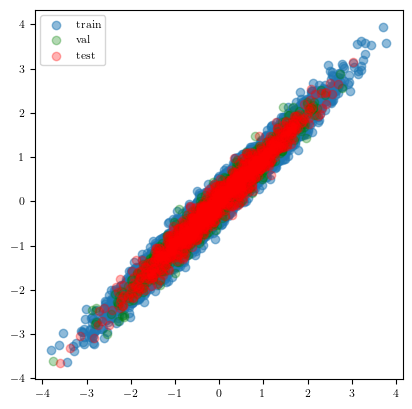

In [45]:
fig, ax = plt.subplots()

ax.scatter(X_train, Y_train, alpha=0.5)
ax.scatter(X_val, Y_val, color='green', alpha=0.3)
ax.scatter(X_test, Y_test, color='red', alpha=0.3)
ax.legend(['train', 'val', 'test'])
# plt.xlabel('x')
# plt.ylabel('y')
ax.set_aspect('equal')
plt.show()

In [48]:
def joint_dist(x, y, sigma_sq):
    return 1/np.sqrt(2*np.pi*sigma_sq) * np.exp(-((y-x)**2)/(2*sigma_sq)) * 1/np.sqrt(2*np.pi) * np.exp(-(x**2)/2)
    # return 1/np.sqrt(2*np.pi*sigma_sq) * np.exp(-((y-x)**2)/(2*sigma_sq)) * 1/np.sqrt(2*np.pi) * np.exp(-(x**2)/(2)) * (p_x(x) * p_y(y))


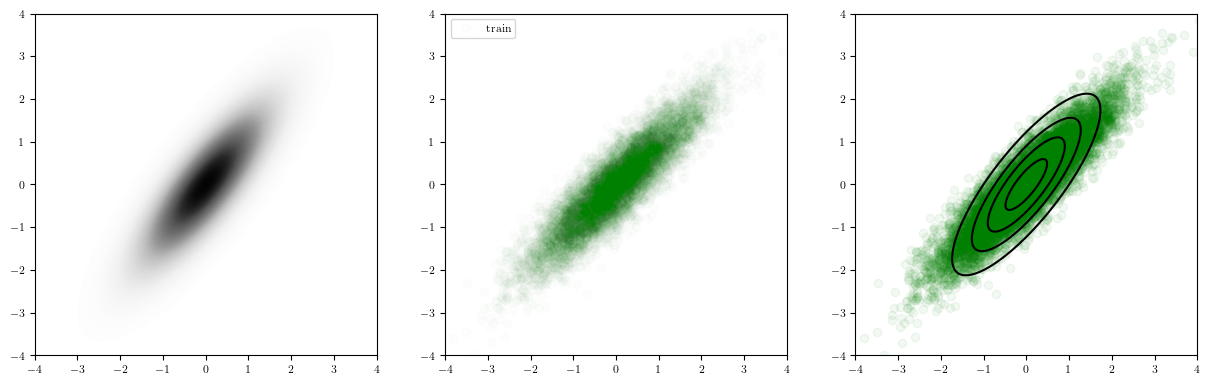

In [65]:
fig, axs = plt.subplots(1,3, figsize=(15,10))

ax = axs[0]
x, y = np.mgrid[-4:4:.01, -4:4:.01]
data = np.dstack((x, y))
z = joint_dist(x, y, sigma_sq)
ax.contourf(x, y, z, 100, cmap='Greys')
# ax.xlabel(r'$x$')
# ax.ylabel(r'$y$')
# ax.title(r'$p(x,y)p(x)p(y)$)')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
ax.set_aspect('equal')

ax = axs[1]
# ax.scatter(X_train, Y_train, alpha=0.002)
ax.scatter(X_train, Y_train, color='green', alpha=0.01)
# ax.scatter(X_test, Y_test, color='red', alpha=0.3)
ax.legend(['train', 'val', 'test'])
# plt.xlabel('x')
# plt.ylabel('y')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
ax.set_aspect('equal')

ax = axs[2]
ax.contour(x, y, z, 4, colors='black', alpha=1)
ax.scatter(X_train, Y_train, color='green', alpha=0.05)
# ax.xlabel(r'$x$')
# ax.ylabel(r'$y$')
# ax.title(r'$p(x,y)p(x)p(y)$)')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
ax.set_aspect('equal')

plt.show()

In [50]:
import seaborn as sns

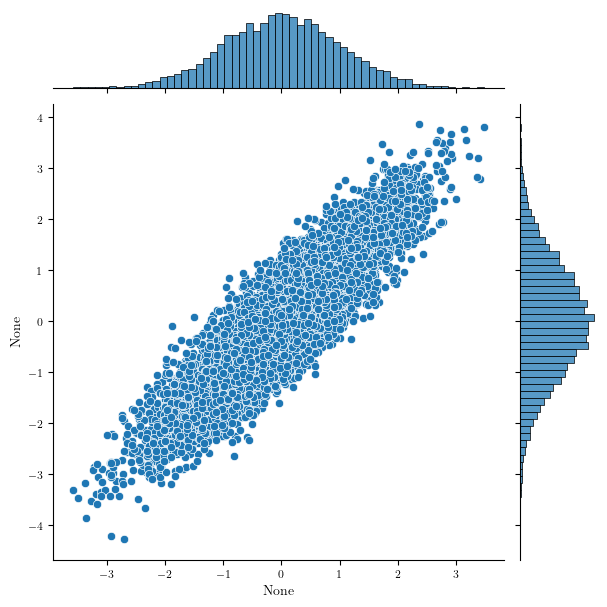

In [60]:
sns.jointplot(x=X_train.squeeze(), y=Y_train.squeeze())

In [55]:
from scipy.stats import linregress

In [68]:
linregress(X_train.squeeze(),Y_train.squeeze())

LinregressResult(slope=0.8961610345646532, intercept=9.48567912264729e-18, rvalue=0.8961610345646535, pvalue=0.0, stderr=0.00443773351031162, intercept_stderr=0.00443773351031162)

In [65]:
np.random.seed(0)
torch.manual_seed(0)

config = {
    'input_shape': X_train.shape[-1],
    'output_shape': 20,
    'n_hidden': 2,
    'layer_size': 256,
    'lr': 1e-3,
    'gamma': 1e-3,
    'epochs': 1e3,
}

# wandb.init(project='NCP_linear', config=config)
# config = wandb.config
config = ml_confs.from_dict(config)

U_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
V_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': config.lr
    }
reg = DeepSVD(U_operator, V_operator, config.output_shape, gamma=config.gamma, device=device)

In [66]:
reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)
# reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs, wandb=wandb)

epoch = 999, loss = -3.3426525592803955: 100%|██████████| 1000/1000 [00:13<00:00, 76.22it/s]


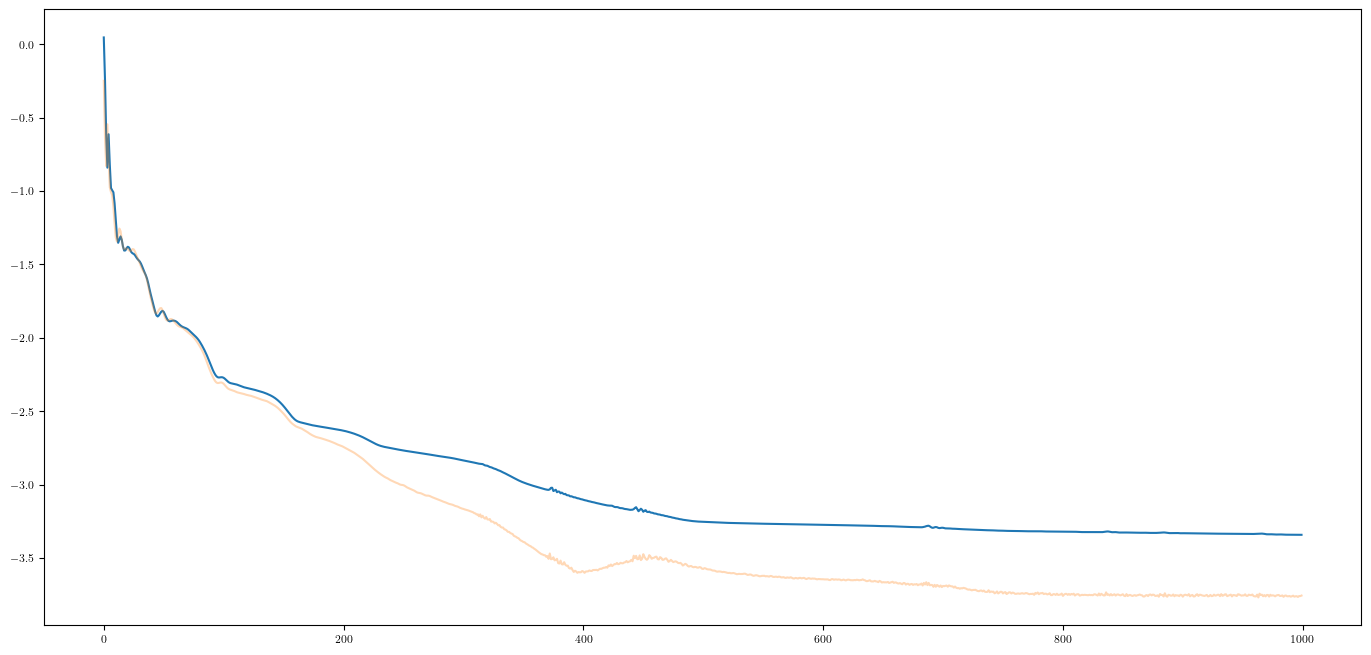

In [67]:
ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

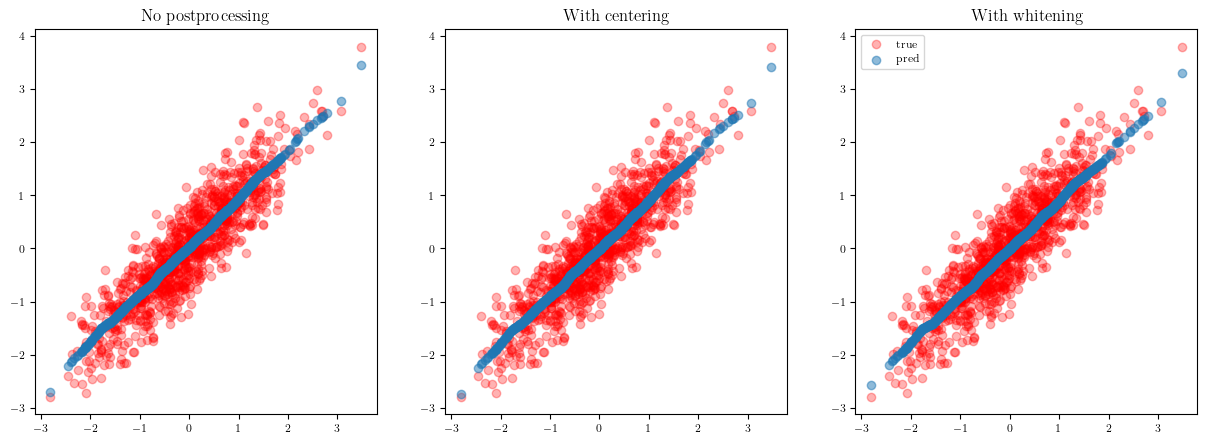

In [68]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = reg.predict(X_test).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = reg.predict(X_test, postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = reg.predict(X_test, postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

In [69]:
def sqrtmh(A: torch.Tensor):
    # Credits to
    """Compute the square root of a Symmetric or Hermitian positive definite matrix or batch of matrices. Credits to  `https://github.com/pytorch/pytorch/issues/25481#issuecomment-1032789228 <https://github.com/pytorch/pytorch/issues/25481#issuecomment-1032789228>`_."""
    L, Q = torch.linalg.eigh(A)
    zero = torch.zeros((), device=L.device, dtype=L.dtype)
    threshold = L.max(-1).values * L.size(-1) * torch.finfo(L.dtype).eps
    L = L.where(L > threshold.unsqueeze(-1), zero)  # zero out small components
    return (Q * L.sqrt().unsqueeze(-2)) @ Q.mH


In [70]:
def centering(model, Ux, Vy):
    Ux_train = model.models['U'](frnp(X_train, device))
    Vy_train = model.models['V'](frnp(Y_train, device))
    
    if Ux.shape[-1] > 1:
        mean_Ux = torch.mean(Ux_train, axis=0)
        mean_Vy = torch.mean(Vy_train, axis=0)
        Ux = Ux - torch.outer(torch.ones(Ux.shape[0], device=model.device), mean_Ux)
        Vy = Vy - torch.outer(torch.ones(Vy.shape[0], device=model.device), mean_Vy)
        
    return Ux, Vy

def whitening(model, Ux, sigma, Vy):
    n = len(X_train)

    Ux = Ux @ torch.diag(sigma)
    Vy = Vy @ torch.diag(sigma)

    Ux_train = model.models['U'](frnp(X_train, device))
    Vy_train = model.models['V'](frnp(Y_train, device))
    Ux_train = Ux_train - torch.outer(torch.ones(Ux_train.shape[0], device=model.device), torch.mean(Ux_train, axis=0))
    Vy_train = Vy_train - torch.outer(torch.ones(Vy_train.shape[0], device=model.device), torch.mean(Vy_train, axis=0))
    
    cov_X = Ux_train.T @ Ux_train * n ** -1
    cov_Y = Vy_train.T @ Vy_train * n ** -1
    cov_XY = Ux_train.T @ Vy_train * n ** -1

    sqrt_cov_X_inv = torch.linalg.pinv(sqrtmh(cov_X))
    sqrt_cov_Y_inv = torch.linalg.pinv(sqrtmh(cov_Y))

    M = sqrt_cov_X_inv @ cov_XY @ sqrt_cov_Y_inv
    e_val, sing_vec_l = torch.linalg.eigh(M @ M.T)
    # print(torch.sqrt(e_val))
    e_val, sing_vec_l = model._filter_reduced_rank_svals(e_val, sing_vec_l)
    sing_val = torch.sqrt(e_val)
    sing_vec_r = (M.T @ sing_vec_l) / sing_val

    Ux = Ux @ sqrt_cov_X_inv @ sing_vec_l
    Vy = Vy @ sqrt_cov_Y_inv @ sing_vec_r
    
    return Ux, sing_val, Vy
        
def get_joint_dist(model, x, y, p_x, p_y, postprocessing = None):
    model.models.eval()
    dims = x.shape
    Ux = model.models['U'](frnp(x.reshape(-1,1), device))
    Vy = model.models['V'](frnp(y.reshape(-1,1), device))
    sigma = torch.sqrt(torch.exp(-model.models['S'].weights ** 2))

    if postprocessing == 'centering':
        Ux, Vy = centering(model, Ux, Vy)
    elif postprocessing == 'whitening':
        Ux, Vy = centering(model, Ux, Vy)
        Ux, sigma, Vy = whitening(model, Ux, sigma, Vy)
    
    Ux, Vy, sigma = tonp(Ux), tonp(Vy), tonp(sigma)

    density = (1 + ((sigma * Ux) * Vy).sum(axis=-1, keepdims=True)).reshape(dims) * p_x(x) * p_y(y)
    # normalization = ((sing_val * Ux) * Ux).sum(axis=-1) * ((sing_val * Vy) * Vy).sum(axis=-1)
    normalization = 1   
    return (density/normalization)

def normalize(x):
    return (x - x.min())/(x.max()-x.min())

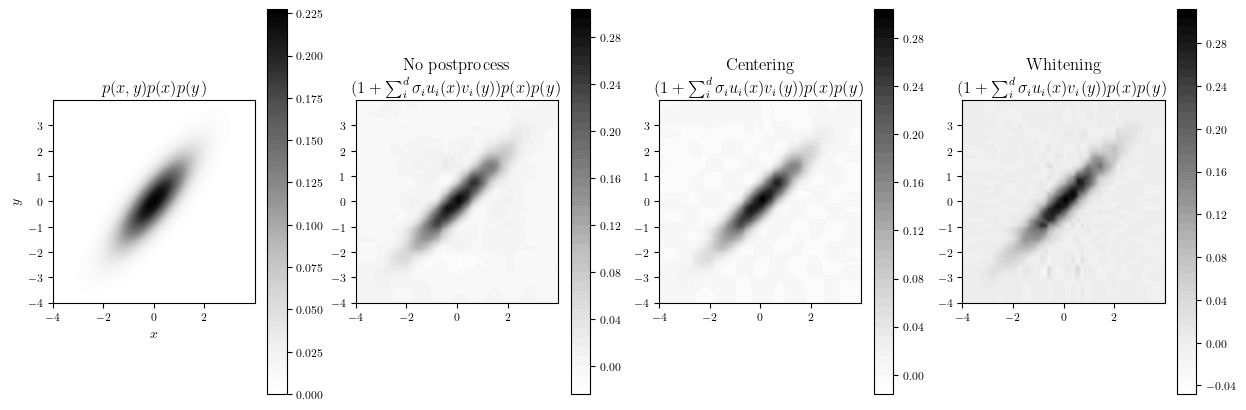

In [73]:
fig, axs = plt.subplots(1,4, figsize=(15,5))
opts = [None, 'centering', 'whitening']

ax = axs[0]
cntf = ax.contourf(x, y, joint_dist(x, y, sigma_sq), 100, cmap='Greys')
plt.colorbar(cntf, ax=ax)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'$p(x,y)p(x)p(y)$')
ax.set_aspect('equal', 'box')

for i, postprocess in enumerate(opts):
    ax = axs[i+1]
    dist = get_joint_dist(reg, x, y, p_x, p_y, postprocess)
    # dist = normalize(dist)
    cntf = ax.contourf(x, y, dist, 50, cmap='Greys')
    plt.colorbar(cntf, ax=ax)
    ax.set_aspect('equal', 'box')
    if postprocess:
        ax.set_title(postprocess.capitalize() + '\n' + r'$(1+\sum_i^d \sigma_i u_i(x) v_i(y)) p(x)p(y)$')
    else:
        ax.set_title('No postprocess' + '\n' + r'$(1+\sum_i^d \sigma_i u_i(x) v_i(y)) p(x)p(y)$')

In [67]:
gammas = [0, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

In [68]:
results = []
for gamma in gammas:
    print(r'Training with gamma = {0}'.format(gamma))
    np.random.seed(0)
    torch.manual_seed(0)
    config = {
        'input_shape': X_train.shape[-1],
        'output_shape': 20,
        'n_hidden': 2,
        'layer_size': 256,
        'lr': 1e-4,
        'gamma': gamma,
        'epochs': 5e3,
    }
    
    # wandb.init(project='NCP_linear', config=config)
    # config = wandb.config
    config = ml_confs.from_dict(config)
    
    U_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
    V_operator = MLPOperator(config.input_shape, config.n_hidden, config.layer_size, config.output_shape)
    
    optimizer = Adam
    optimizer_kwargs = {
        'lr': config.lr
        }
    model = DeepSVD(U_operator, V_operator, config.output_shape, gamma=config.gamma, device=device)
    model.fit(X_train, Y_train, X_val, Y_val, epochs=int(config.epochs), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)
    
    results.append({'gamma':gamma, 'model':model})

Training with gamma = 0


epoch = 4999, loss = -690.6494750976562: 100%|██████████| 5000/5000 [00:56<00:00, 88.39it/s] 


Training with gamma = 0.001


epoch = 4999, loss = -1735.1295166015625: 100%|██████████| 5000/5000 [01:07<00:00, 74.51it/s]


Training with gamma = 0.01


epoch = 4999, loss = -1298.338623046875: 100%|██████████| 5000/5000 [01:08<00:00, 72.65it/s] 


Training with gamma = 0.1


epoch = 4999, loss = -335.2760009765625: 100%|██████████| 5000/5000 [01:09<00:00, 72.02it/s]  


Training with gamma = 1


epoch = 4999, loss = -106.17037963867188: 100%|██████████| 5000/5000 [01:08<00:00, 72.94it/s]  


Training with gamma = 10


epoch = 4999, loss = 35.97087478637695: 100%|██████████| 5000/5000 [01:08<00:00, 72.79it/s] 


Training with gamma = 100


epoch = 4999, loss = 393.4060363769531: 100%|██████████| 5000/5000 [01:07<00:00, 73.72it/s] 


Training with gamma = 1000


epoch = 4999, loss = 4901.6611328125: 100%|██████████| 5000/5000 [01:08<00:00, 72.62it/s] 


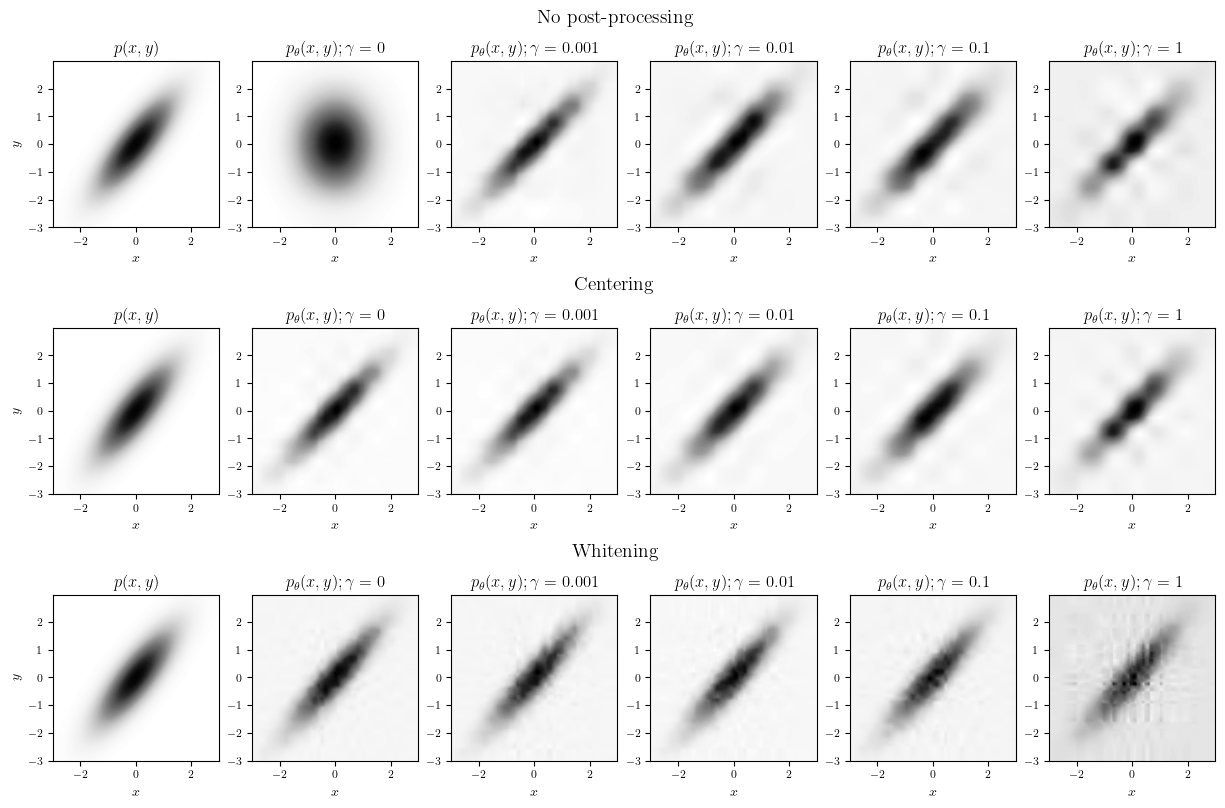

In [52]:
fig = plt.figure(figsize=(15,8))
x, y = np.mgrid[-3:3:.01, -3:3:.01]

postproc = [None, 'centering', 'whitening']
subfigs = fig.subfigures(nrows=len(postproc), ncols=1)
for row, subfig in enumerate(subfigs):
    if postproc[row] is None:
        subfig.suptitle("No post-processing", size=14, y=1)
    else:
        subfig.suptitle(postproc[row].capitalize(), size=14, y=1)
    axs = subfig.subplots(nrows=1, ncols=len(results)+1)
    for j, dict in enumerate(results):
        if j == 0:
            ax = axs[j]
            ax.contourf(x, y, joint_dist(x, y, sigma_sq, p_x, p_y), 100, cmap='Greys')
            # ax.colorbar(ticks=[0,.25,.5,.75,1], label=r'$p(x,y)$')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            ax.set_title(r'$p(x,y)$')
            ax.set_aspect('equal')
        ax=axs[j+1]
        gamma = dict['gamma']
        model = dict['model']
        dist = get_joint_dist(model, x, y, p_x, p_y, postprocessing=postproc[row])
        dist = (dist-dist.min())/(dist.max()-dist.min()) 
        ax.contourf(x, y, dist, 100, cmap='Greys')
        ax.set_title(r'gamma = ' + str(gamma))
        ax.set_xlabel(r'$x$')
        ax.set_title(r"$p_\theta(x,y); \gamma = {0}$".format(gamma))
        ax.set_aspect('equal')

# plt.tight_layout()
plt.show() 

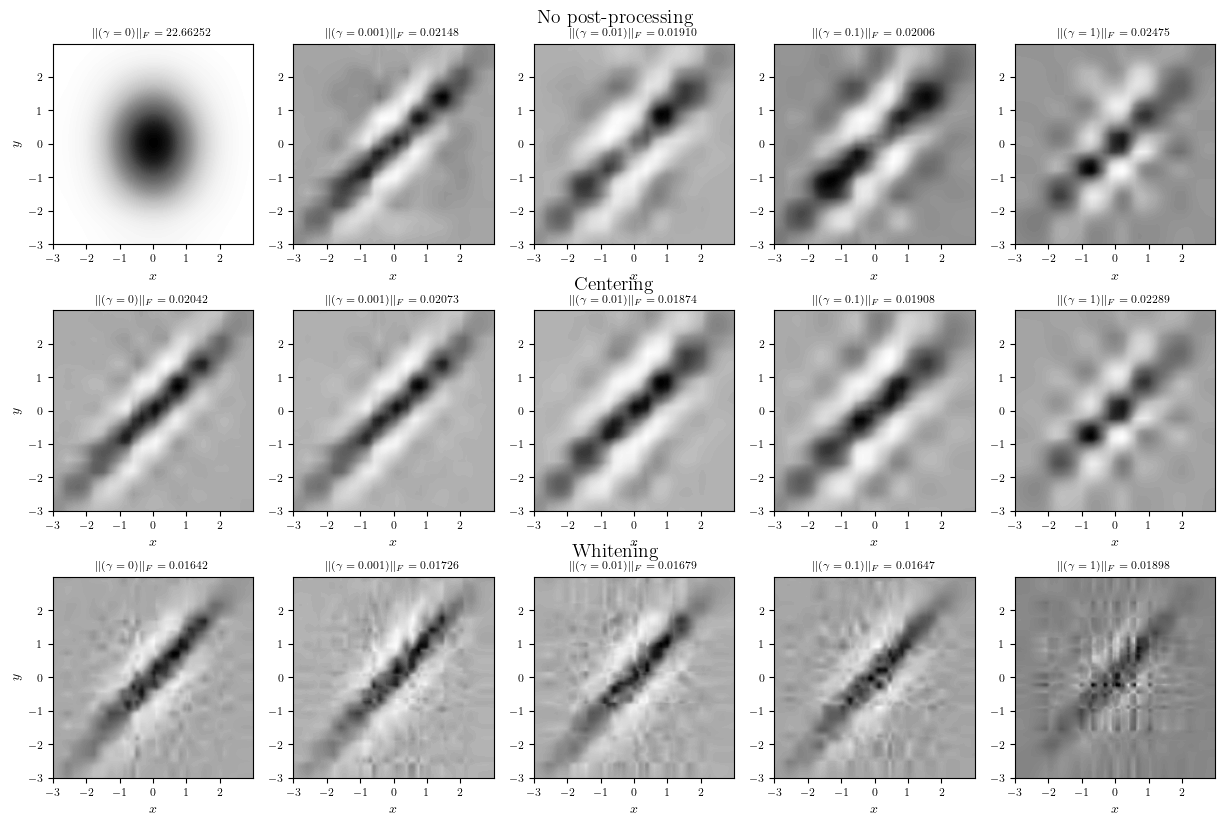

In [55]:
p_xy = joint_dist(x, y, sigma_sq, p_x, p_y)
# p_xy = normalize(p_xy)

fig = plt.figure(figsize=(15,8))
postproc = [None, 'centering', 'whitening']
subfigs = fig.subfigures(nrows=len(postproc), ncols=1)
for row, subfig in enumerate(subfigs):
    if postproc[row] is None:
        subfig.suptitle("No post-processing", size=14, y=1)
    else:
        subfig.suptitle(postproc[row].capitalize(), size=14, y=1)
    axs = subfig.subplots(nrows=1, ncols=len(results))
    axs[0].set_ylabel(r'$y$')
    for j, dict in enumerate(results):
        ax=axs[j]
        gamma = dict['gamma']
        model = dict['model']
        dist = get_joint_dist(model, x, y, p_x, p_y, postprocessing=postproc[row])
        # dist = normalize(dist)
        ax.contourf(x, y, dist - p_xy, 100, cmap='Greys')
        ax.set_title(r'gamma = ' + str(gamma))
        ax.set_xlabel(r'$x$')
        # ax.set_title(r"$||p - p_\theta(\gamma={0})||_F = {1:0.2f}$".format(gamma, np.linalg.norm(dist - p_xy)/dist.squeeze().shape[0]), size=8)
        ax.set_title(r"$||(\gamma={0})||_F = {1:0.5f}$".format(gamma, np.linalg.norm(dist - p_xy)/dist.squeeze().shape[0]), size=8)
        ax.set_aspect('equal')

# plt.tight_layout()
plt.show()

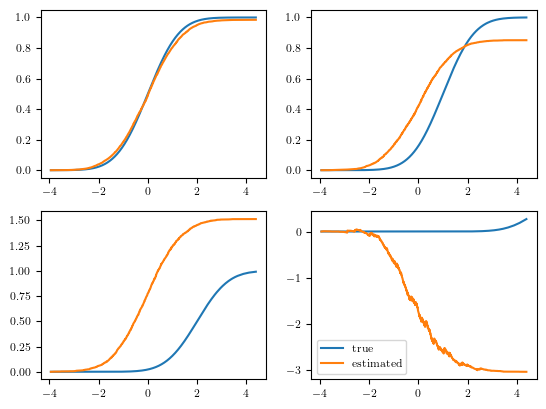

In [58]:
from scipy.stats import norm
from NCP.cdf import get_cdf

fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 2, 5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]])).to(device)
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess = None)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    cdf_unscaled = cdf_pred

    # true_cdf = norm.cdf(fys, loc=xi**1, scale=np.sqrt(1+np.abs(xi)))
    true_cdf = norm.cdf(fys, loc=xi, scale=1)

    axes[i].plot(fys, true_cdf, label = 'true')
    axes[i].plot(fys, cdf_unscaled, label = 'estimated')
    #axes[i].text(1., 1., 'KL: ', kullback_leibler( cdf_unscaled, true_cdf), horizontalalignement='left')
    #axes[i].text(0.5, 0.5,'Hellinger: ', hellinger(cdf_unscaled, true_cdf), horizontalalignement='left')
    #axes[i].text(0.5, 0.5,'Wasserstein: ', wasserstein1(cdf_unscaled, true_cdf), horizontalalignement='left')

plt.legend()
plt.show()

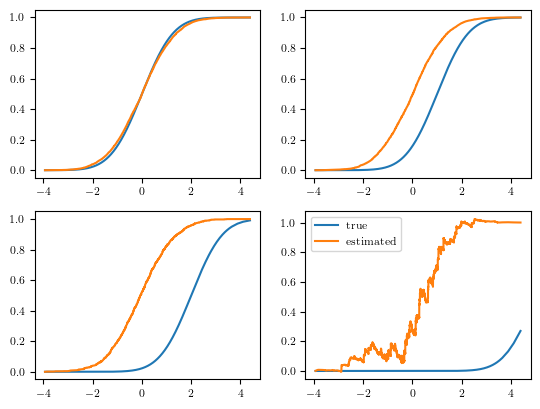

In [59]:
from scipy.stats import norm
from NCP.cdf import get_cdf

fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 2, 5]):
    x_scaled = torch.Tensor(xscaler.transform([[xi]])).to(device)
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess = 'centering')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    cdf_unscaled = cdf_pred
    
    # true_cdf = norm.cdf(fys, loc=xi**1, scale=np.sqrt(1+np.abs(xi)))
    true_cdf = norm.cdf(fys, loc=xi, scale=1)

    axes[i].plot(fys, true_cdf, label = 'true')
    axes[i].plot(fys, cdf_unscaled, label = 'estimated')
    #axes[i].text(1., 1., 'KL: ', kullback_leibler( cdf_unscaled, true_cdf), horizontalalignement='left')
    #axes[i].text(0.5, 0.5,'Hellinger: ', hellinger(cdf_unscaled, true_cdf), horizontalalignement='left')
    #axes[i].text(0.5, 0.5,'Wasserstein: ', wasserstein1(cdf_unscaled, true_cdf), horizontalalignement='left')

plt.legend()
plt.show()

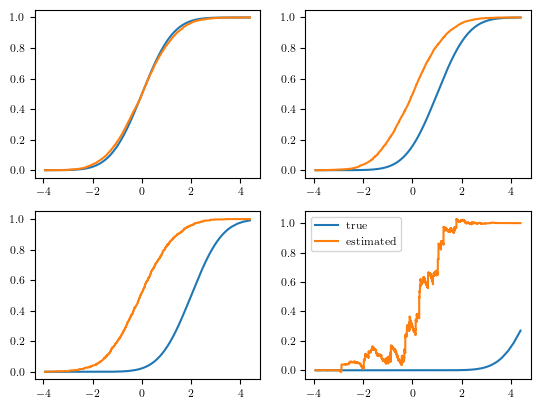

In [60]:
from scipy.stats import norm
from NCP.cdf import get_cdf

fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 2, 5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]])).to(device)
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess = 'whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    cdf_unscaled = cdf_pred

    # true_cdf = norm.cdf(fys, loc=xi**1, scale=np.sqrt(1+np.abs(xi)))
    true_cdf = norm.cdf(fys, loc=xi, scale=1)
    
    axes[i].plot(fys, true_cdf, label = 'true')
    axes[i].plot(fys, cdf_unscaled, label = 'estimated')
    #axes[i].text(1., 1., 'KL: ', kullback_leibler( cdf_unscaled, true_cdf), horizontalalignement='left')
    #axes[i].text(0.5, 0.5,'Hellinger: ', hellinger(cdf_unscaled, true_cdf), horizontalalignement='left')
    #axes[i].text(0.5, 0.5,'Wasserstein: ', wasserstein1(cdf_unscaled, true_cdf), horizontalalignement='left')

plt.legend()
plt.show()

In [76]:
from cde.density_simulation import SkewNormal

""" simulate some data """
density_simulator = SkewNormal(random_seed=22)
X, Y = density_simulator.simulate(n_samples=3000)


ModuleNotFoundError: No module named 'cde.utils'